<a href="https://colab.research.google.com/github/Shuo-Zh/dl/blob/main/encoder-decoder/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN
- 编码，将文本表示称向量（编码器处理输出）
- 解码，将向量表示成输出（解码器处理输出）
Input -> Encoder -> State -> Decoder -> Output
Input -> Decoder

In [3]:
# 编码器
from torch import nn

class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [4]:
# 解码器
class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [5]:
# 合并编码器和解码器
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

## 总结
- 编码器－解码器”架构可以将长度可变的序列作为输入和输出，因此适用于机器翻译等序列转换问题。

- 编码器将长度可变的序列作为输入，并将其转换为具有固定形状的编码状态。

- 解码器将具有固定形状的编码状态映射为长度可变的序列。

# seq2seq
最早做机器翻译
- encoder 和 decoder 架构
- 编码器是一个 RNN，读取输入句子
  - 可以是双向，经常用到encoder
- 解码器使用另外一个 RNN 来输出


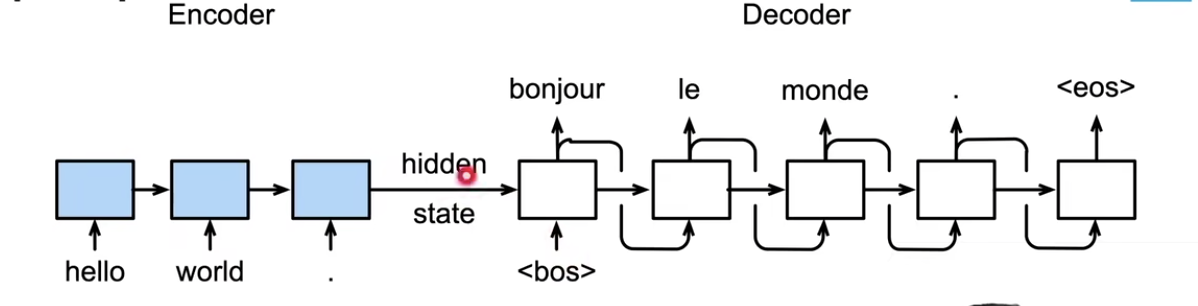

- 编码器是没有输出的的 RNN
- 解码器最后时间步的隐状态
- 编码器最后时间步的状态用作解码器的初始隐状态

###训练
- 训练时解码器使用目标句子作为输入

### 推理
- 推理只能用上一时刻输出作为下一时刻的输入

### 衡量生成序列的好坏BLEU
- p_n 是预测 n-gram 的精度
  - 标签序列 A B C D E F 和预测序列 A B B C D，有 p1 = 4/5, p2 = 3/4, p3 = 1/3, p4 = 0
- BLEU定义（Bilingual Evaluation）
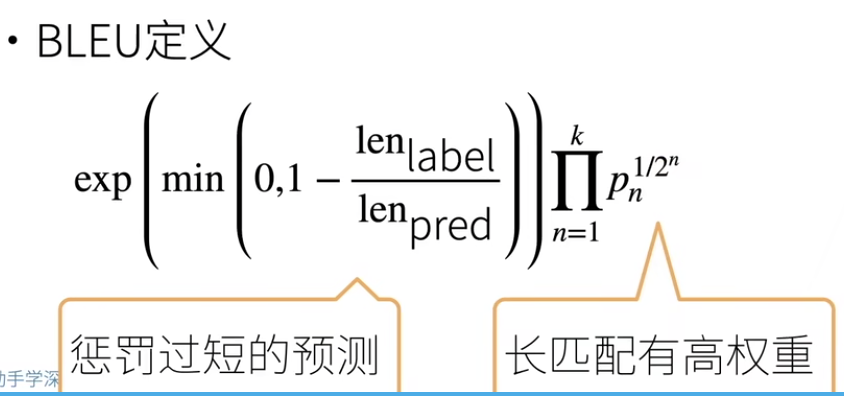


# 总结
- Seq2seq 从一个句子生成另一个句子
- 编码器和解码器 都是 RNN
- 将编码器最后时间隐状态 来初始解码器隐状态来完成信息传递
- 使用 BLEU 来衡量生成序列的好坏

In [6]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

In [22]:
vocab_size=10
embed_size=8
num_hiddens=16
num_layers=2
dropout=0

nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

GRU(8, 16, num_layers=2)

In [7]:
# 实现循环神经网络
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [14]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval() # dropout 不生效
X = torch.zeros((4, 7), dtype=torch.long) # 4 batch_size, 7句子长度
output, state = encoder(X) # 创建一个形状为 (4, 7) 的 LongTensor X，并将所有元素初始化为零：
print(output.shape)
print("每一个时刻", "batch size", "隐藏层")

torch.Size([7, 4, 16])
每一个时刻 batch size 隐藏层


In [16]:
state.shape

torch.Size([2, 4, 16])

In [18]:
# Decoder
class Seq2SeqDecoder(d2l.Decoder):
  """用于序列到序列学习的循环神经网络解码器"""
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                dropout=0, **kwargs):
      super(Seq2SeqDecoder, self).__init__(**kwargs)
      self.embedding = nn.Embedding(vocab_size, embed_size)
      self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                        dropout=dropout)
      self.dense = nn.Linear(num_hiddens, vocab_size) #输入 num_hiddens, 输出 vocab_size

  def init_state(self, enc_outputs, *args):
      return enc_outputs[1] # outputs 包括 output/ state

  def forward(self, X, state):
      # 输出'X'的形状：(batch_size,num_steps,embed_size)
      X = self.embedding(X).permute(1, 0, 2)
      # 广播context，使其具有与X相同的num_steps
      context = state[-1].repeat(X.shape[0], 1, 1) # context 上下文
      X_and_context = torch.cat((X, context), 2) # concat 起来
      output, state = self.rnn(X_and_context, state)
      output = self.dense(output).permute(1, 0, 2)
      # output的形状:(batch_size,num_steps,vocab_size)
      # state的形状:(num_layers,batch_size,num_hiddens)
      return output, state

In [19]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape
# batch_size, 序列长度, vocab_size ; 层数, batch_size, number of hiddens

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

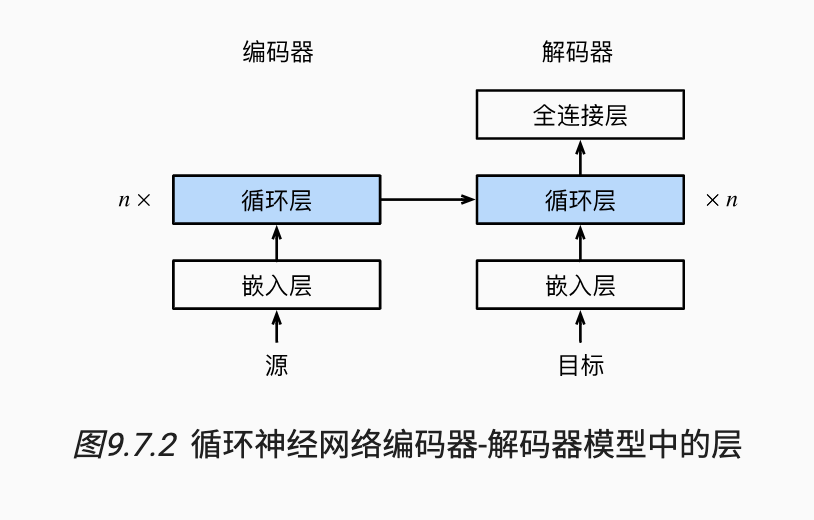